#FC

##Definitions

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from numpy import linalg as LA

##FC implimentation


In [ ]:
!pip install torch-summary
from torchsummary import summary

In [ ]:
class SimpleFC(nn.Module):
  def __init__(self, input_dim , layer_1 , layer_2, output_dim):
    super(SimpleFC, self).__init__()
    #torch.manual_seed(501)
    # random.seed(501)
    #np.random.seed(501)

    self.fc1 = None
    self.fc2 = None
    self.fc3 = None
    self.fc1 =  nn.Linear(input_dim, layer_1)
    self.fc2 =  nn.Linear(layer_1, layer_2)
    self.fc3 =  nn.Linear(layer_2, output_dim)
  def forward(self, x):
    
    x= self.fc1(x)
    x= nn.functional.relu(x)
    x= self.fc2(x)
    x= nn.functional.relu(x)
    x= self.fc3(x)
    x= nn.functional.relu(x)
    ###########################################################
    #                         END OF YOUR CODE                #
    ###########################################################
    return x

##Optimizer

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
def get_training_components(learnable_params, init_lr, step_size=None, gamma=None):
  '''
  Function to prepare components of the training. These are all the same
  throughout the experiments made.
  '''
  # The problem always be a image classification
  criterion = nn.CrossEntropyLoss()
  # Which parameters to be updated depends on if the training is done from scratch
  # or with pre-trained model.
  optimizer = optim.SGD(learnable_params, lr=init_lr, momentum=0.9)
  # Step size depends on the # of epoch
  if step_size is not None:
    scheduler = StepLR(optimizer, step_size, gamma)
    return (criterion, optimizer, scheduler)
  return (criterion, optimizer)

In [ ]:
def get_device():
  if torch.cuda.is_available():
    print("Cuda (GPU support) is available and enabled!")
    device = torch.device("cuda")
  else:
    print("Cuda (GPU support) is not available :(")
    device = torch.device("cpu")
device = get_device()

Cuda (GPU support) is not available :(


##Trainer

In [ ]:
def train(model, criterion, optimizer, epochs, dataloader, device, input_dim, scheduler=None, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the loss history.
  """
  loss_history = [] 
  
  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):    
      
      # Our batch:
      inputs  = data[:,:input_dim].float() 
      labels  = data[:,input_dim:].long()
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model.forward(inputs)
      
      # Calculate loss
      outputs = outputs.to(device)
      
      loss = criterion(outputs, labels[:,0])

      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      loss_history.append(loss.item())
      
      
    if verbose: print(f'Epoch {epoch} / {epochs}: avg. train loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return loss_history 

##Training

###Appendix E1, Left Plot


In [ ]:
def get_learnable_parameters(model):
  params_to_update = []
  for name, param in model.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)
  return params_to_update

In [ ]:
input_dim = 10 
layer_1 = 2048
layer_2 = 256
output_dim = 10
data_size = 10000

In [ ]:
A = np.random.randint(output_dim, size=data_size)
B = np.zeros((data_size, 1))
for i in range(data_size):
  B[i,:]=A[i]
Labels = B

Synthetic data given in the paper is generated using the synthetic covariance matrix:

In [ ]:
#Synthetic data given in the paper is generated using the synthetic covariance matrix:
Cov= np.diag(np.arange(1,2.0,0.1))
Mean = np.zeros(Cov.shape[0])
synthetic_data = np.random.multivariate_normal(Mean, Cov, data_size)

Synthetic data given is prepared as input data:

In [ ]:
#Synthetic data given prepared as input data:
Data_All = np.zeros((data_size,input_dim+1))
Data_All[:,:input_dim] = synthetic_data
Data_All[:,input_dim:] = Labels

In [ ]:
batch_size = 128
trainloader = torch.utils.data.DataLoader(Data_All, batch_size=batch_size, shuffle=True, num_workers=2)

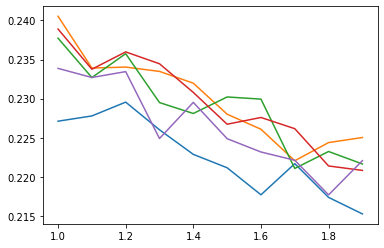

In [ ]:
iteration_no = 5

for i in range(iteration_no):
  FC = SimpleFC(input_dim, layer_1,layer_2,output_dim)
  epochs = 200
  learning_rate = 0.01
  learnable_parameters = get_learnable_parameters(FC)
  criterion, optimizer = get_training_components(learnable_parameters, learning_rate)
  loss_history = train(FC, criterion, optimizer, epochs, trainloader, device, input_dim, verbose=False)

  #Calculation of first layer weight eigenvalues as explained in paper:
  Cov_y = np.cov(FC.fc1.weight.detach().numpy().T)
  w_x, v_x = LA.eig(Cov)
  plt.plot(np.diag(Cov), np.sqrt(np.diag(np.matmul(np.matmul( v_x.T , Cov_y ), v_x[:])  )))
plt.show()

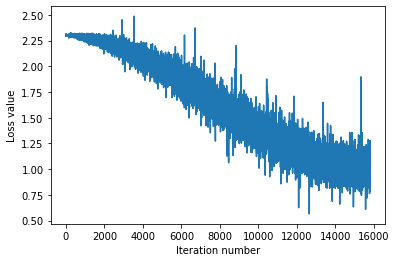

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

###Appendix E1, Middle Plot (Also Figure 4 Left)


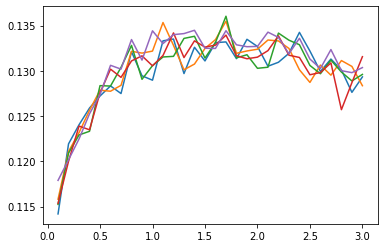

In [ ]:
input_dim = 30 
layer_1 = 2048
layer_2 = 256
output_dim = 10
data_size = 10000

A = np.random.randint(output_dim, size=data_size)
B = np.zeros((data_size, 1))
for i in range(data_size):
  B[i,:]=A[i]
Labels = B

#Synthetic data given in the paper is generated using the synthetic covariance matrix:
Cov= np.diag(np.arange(0.1,3.1,0.1))
Mean = np.zeros(Cov.shape[0])
synthetic_data = np.random.multivariate_normal(Mean, Cov, data_size)

#Synthetic data given prepared as input data:
Data_All = np.zeros((data_size,input_dim+1))
Data_All[:,:input_dim] = synthetic_data
Data_All[:,input_dim:] = Labels

batch_size = 128
trainloader = torch.utils.data.DataLoader(Data_All, batch_size=batch_size, shuffle=True, num_workers=2)

iteration_no = 5

for i in range(iteration_no):
  FC = SimpleFC(input_dim, layer_1,layer_2,output_dim)
  epochs = 200
  learning_rate = 0.01
  learnable_parameters = get_learnable_parameters(FC)
  criterion, optimizer = get_training_components(learnable_parameters, learning_rate)
  loss_history = train(FC, criterion, optimizer, epochs, trainloader, device, input_dim,  verbose=False)
  
  #Calculation of first layer weight eigenvalues as explained in paper:
  Cov_y = np.cov(FC.fc1.weight.detach().numpy().T)
  w_x, v_x = LA.eig(Cov)
  plt.plot(np.diag(Cov), np.sqrt(np.diag(np.matmul(np.matmul( v_x.T , Cov_y ), v_x[:])  )))
plt.show()

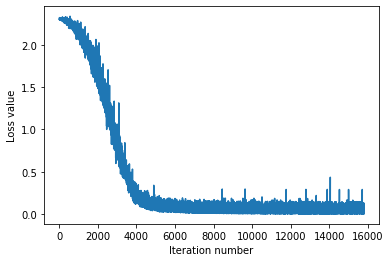

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()


### Appendix E, Right Plot

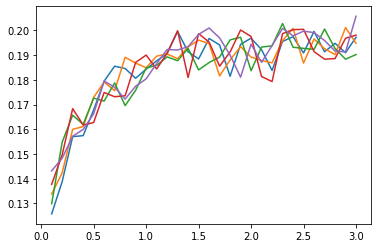

In [ ]:
input_dim = 30 
layer_1 = 256
layer_2 = 256
output_dim = 10
data_size = 2000

A = np.random.randint(output_dim, size=data_size)
B = np.zeros((data_size, 1))
for i in range(data_size):
  B[i,:]=A[i]
Labels = B

#Synthetic data given in the paper is generated using the synthetic covariance matrix:
Cov= np.diag(np.arange(0.1,3.1,0.1))
Mean = np.zeros(Cov.shape[0])
synthetic_data = np.random.multivariate_normal(Mean, Cov, data_size)

#Synthetic data given prepared as input data:
Data_All = np.zeros((data_size,input_dim+1))
Data_All[:,:input_dim] = synthetic_data
Data_All[:,input_dim:] = Labels

batch_size = 128
trainloader = torch.utils.data.DataLoader(Data_All, batch_size=batch_size, shuffle=True, num_workers=2)

iteration_no = 5

for i in range(iteration_no):
  FC = SimpleFC(input_dim, layer_1,layer_2,output_dim)
  epochs = 200
  learning_rate = 0.01
  learnable_parameters = get_learnable_parameters(FC)
  criterion, optimizer = get_training_components(learnable_parameters, learning_rate)
  loss_history = train(FC, criterion, optimizer, epochs, trainloader, device, input_dim,  verbose=False)

  #Calculation of first layer weight eigenvalues as explained in paper:
  Cov_y = np.cov(FC.fc1.weight.detach().numpy().T)
  w_x, v_x = LA.eig(Cov)
  plt.plot(np.diag(Cov), np.sqrt(np.diag(np.matmul(np.matmul( v_x.T , Cov_y ), v_x[:])  )))


plt.show()

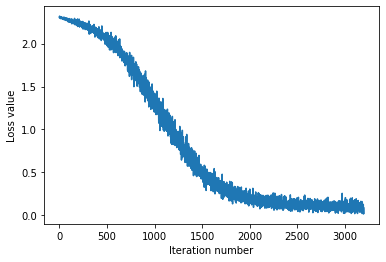

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()
